**Reconstruction comparisons**

In [1]:
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
from tqdm import tqdm

from cplAE_TE.utils.analysis_helpers import pc_cca, reconstruction_metrics
from cplAE_TE.utils.load_helpers import get_paths, load_dataset, load_summary_files

In [2]:
O = load_dataset(min_sample_thr=10)
path = get_paths()

#### Coupled autoencoder reconstructions

In [3]:

#Experiment configurations for reconstruction accuracy:
config = {}

config['uncoupled']         = {'alpha_T': 1.0, 'alpha_E': 1.0, 'latent_dim': 3, 'n_cvfolds': 44, 'lambda_TE': 0.0, 'aug': 0}
config['coupled_0-5']       = {'alpha_T': 1.0, 'alpha_E': 1.0, 'latent_dim': 3, 'n_cvfolds': 44, 'lambda_TE': 0.5, 'aug': 1}
config['coupled_1-0']       = {'alpha_T': 1.0, 'alpha_E': 1.0, 'latent_dim': 3, 'n_cvfolds': 44, 'lambda_TE': 1.0, 'aug': 1}
config['coupled_1-0_aug_0'] = {'alpha_T': 1.0, 'alpha_E': 1.0, 'latent_dim': 3, 'n_cvfolds': 44, 'lambda_TE': 1.0, 'aug': 0}
config['coupled_1-0_5d']    = {'alpha_T': 1.0, 'alpha_E': 1.0, 'latent_dim': 5, 'n_cvfolds': 44, 'lambda_TE': 1.0, 'aug': 1}
config['coupled_1-0_10d']   = {'alpha_T': 1.0, 'alpha_E': 1.0, 'latent_dim': 10, 'n_cvfolds': 44, 'lambda_TE': 1.0, 'aug': 1}

key_list = ['XrT','XrE_from_XT','XrT_from_XE','XrE','zE','zT','train_ind','val_ind','test_ind']

In [4]:
for key in config.keys():
    print(f'\nStarting experiment {key}')
    cfg = config[key]

    #Get saved representations
    path = get_paths()
    CVdict = load_summary_files(data_type='NM',
                                alpha_T=cfg['alpha_T'],
                                alpha_E=cfg['alpha_E'],
                                lambda_TE=cfg['lambda_TE'],
                                latent_dim=cfg['latent_dim'],
                                aug=cfg['aug'],
                                fold_list=np.arange(cfg['n_cvfolds']),
                                key_list=key_list)
    
    #Get reconstruction metrics for each fold
    result_df_list = []
    for cv in tqdm(CVdict.keys()):
        result_df = reconstruction_metrics(XT=O['XT'],
                                           XE=O['XE'],
                                           Fold=CVdict[cv],
                                           subset_list=['train', 'val', 'test'])
        result_df_list.append(result_df)

    #Save result for all folds
    result_df = pd.concat(result_df_list)
    fname = f'reconstruction' +\
        f'_aT_{cfg["alpha_T"]:0.1f}' +\
        f'_aE_{cfg["alpha_E"]:0.1f}' +\
        f'_cs_{cfg["lambda_TE"]:0.1f}' +\
        f'_ad_{cfg["aug"]:d}' +\
        f'_ld_{cfg["latent_dim"]:d}'
    fname = fname.replace('.', '-')+'.csv'
    result_df.to_csv('../assets/'+fname)
    


Starting experiment uncoupled
Loading aT_1-0_aE_1-0_cs_0-0_ad_0
100%|██████████| 44/44 [00:09<00:00,  4.59it/s]

Starting experiment coupled_0-5
Loading aT_1-0_aE_1-0_cs_0-5_ad_1
100%|██████████| 44/44 [00:09<00:00,  4.71it/s]

Starting experiment coupled_1-0
Loading aT_1-0_aE_1-0_cs_1-0_ad_1
100%|██████████| 44/44 [00:09<00:00,  4.57it/s]

Starting experiment coupled_1-0_aug_0
Loading aT_1-0_aE_1-0_cs_1-0_ad_0
100%|██████████| 44/44 [00:09<00:00,  4.77it/s]

Starting experiment coupled_1-0_5d
Loading aT_1-0_aE_1-0_cs_1-0_ad_1
100%|██████████| 44/44 [00:09<00:00,  4.62it/s]

Starting experiment coupled_1-0_10d
Loading aT_1-0_aE_1-0_cs_1-0_ad_1
100%|██████████| 44/44 [00:09<00:00,  4.49it/s]


#### Reconstructions obtained with linear baselines

In [5]:
#CVdict only loads indices (training, validation, ...):
cfg = {'alpha_T': 1.0, 'alpha_E': 1.0, 'latent_dim': 3, 'n_cvfolds': 44,
       'lambda_TE': 1.0, 'aug': 1, 'representation_id': 'zT'}
key_list = ['train_ind', 'val_ind', 'test_ind']

path = get_paths()
Folds = load_summary_files(data_type='NM',
                            alpha_T=cfg['alpha_T'],
                            alpha_E=cfg['alpha_E'],
                            lambda_TE=cfg['lambda_TE'],
                            latent_dim=cfg['latent_dim'],
                            aug=cfg['aug'],
                            fold_list=np.arange(cfg['n_cvfolds']),
                            key_list=key_list)

del cfg

Loading aT_1-0_aE_1-0_cs_1-0_ad_1


In [6]:
config = {}
config['50-50-pc-3-cc'] = {'pc_dim_T': 50, 'pc_dim_E': 50, 'cca_dim': 3}
config['10-10-pc-3-cc'] = {'pc_dim_T': 10, 'pc_dim_E': 10, 'cca_dim': 3}
config['50-50-pc-3-cc_5d'] = {'pc_dim_T': 50, 'pc_dim_E': 50, 'cca_dim': 5}
config['50-50-pc-3-cc_10d'] = {'pc_dim_T': 50, 'pc_dim_E': 50, 'cca_dim': 10}

In [7]:
for key in config.keys():
    print(f'\nStarting experiment {key}')
    cfg = config[key]
    CVdict = deepcopy(Folds)

    #For each of the folds, perform pc-cca with the same training/validation splits and obtain the reconstruction.
    for cv in CVdict.keys():
        _, _, CVdict[cv]['XrT'] ,CVdict[cv]['XrE'] ,CVdict[cv]['XrT_from_XE'] ,CVdict[cv]['XrE_from_XT'] = pc_cca(XT=deepcopy(O['XT']),
                                                        XE=deepcopy(O['XE']),
                                                        train_ind=CVdict[cv]['train_ind'],
                                                        pc_dim_T=cfg['pc_dim_T'],
                                                        pc_dim_E=cfg['pc_dim_E'],
                                                        cca_dim=cfg['cca_dim'])

    #Get reconstruction metrics for each fold
    result_df_list = []
    for cv in tqdm(CVdict.keys()):
        result_df = reconstruction_metrics(XT=O['XT'],
                                           XE=O['XE'],
                                           Fold=CVdict[cv],
                                           subset_list=['train', 'val', 'test'])
        result_df_list.append(result_df)

    #Save result for all folds
    result_df = pd.concat(result_df_list)

    fname = f'reconstruction' +\
        f'_pc_dim_T_{cfg["pc_dim_T"]:d}' +\
        f'_pc_dim_E_{cfg["pc_dim_E"]:d}' +\
        f'_cca_dim_{cfg["cca_dim"]:d}'
    fname = fname.replace('.', '-')+'.csv'
    result_df.to_csv('../assets/'+fname)


Starting experiment 50-50-pc-3-cc
100%|██████████| 44/44 [00:09<00:00,  4.71it/s]

Starting experiment 10-10-pc-3-cc
100%|██████████| 44/44 [00:09<00:00,  4.44it/s]

Starting experiment 50-50-pc-3-cc_5d
100%|██████████| 44/44 [00:09<00:00,  4.50it/s]

Starting experiment 50-50-pc-3-cc_10d
100%|██████████| 44/44 [00:10<00:00,  4.35it/s]


#### Plot results to compare reconstruction performance against baselines
 
These results are included as Figure 1f in [Gala et al. 2021](https://www.nature.com/articles/s43588-021-00030-1)

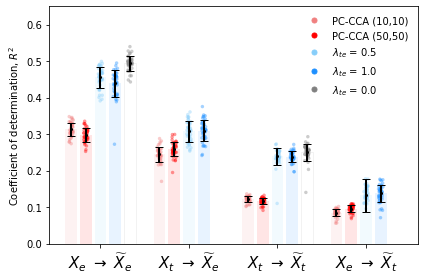

In [8]:

result_path = Path('../assets')
fname_list = ['reconstruction_pc_dim_T_10_pc_dim_E_10_cca_dim_3.csv',\
              'reconstruction_pc_dim_T_50_pc_dim_E_50_cca_dim_3.csv',\
              'reconstruction_aT_1-0_aE_1-0_cs_0-5_ad_1_ld_3.csv',\
              'reconstruction_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_3.csv',\
              'reconstruction_aT_1-0_aE_1-0_cs_0-0_ad_0_ld_3.csv']
df_list = []

for fname in fname_list:
    df_list.append(pd.read_csv((result_path / fname).resolve()))

#Remove single cross validation fold from all - corrupted reconstruction data in one of the experiment configurations. 
for df in df_list: df.drop(index=35,inplace=True)


col = ['lightcoral',
       'red',
       'lightskyblue',
       'dodgerblue',
       'gray']

lbl = ['PC-CCA (10,10)',
       'PC-CCA (50,50)',
       r'$\lambda_{te}$ = 0.5',
       r'$\lambda_{te}$ = 1.0',
       r'$\lambda_{te}$ = 0.0']

h_list = []

plt.figure(figsize=(6, 4))
for grp, key in enumerate(['XE_from_XE_',
                           'XE_from_XT_',
                           'XT_from_XT_',
                           'XT_from_XE_']):

    meas = 'R2_val'
    key = key+meas

    for i, df in enumerate(df_list):
        x_value = i+(6*grp)
        y_values = df[key].values
        x_values_scattered = x_value * \
            np.ones_like(y_values) + (np.random.rand(y_values.size,)-0.5)*0.3
        
        #Cross-modality reconstructions
        if (key in ['XE_from_XT_'+meas, 'XT_from_XE_'+meas]):
            if not(col[i] == 'gray'):  # i.e. if lambda_TE=0
                plt.bar(x_value, np.mean(y_values), color=col[i], alpha=0.1)
                plt.scatter(x=x_values_scattered, y=y_values, s=12, c=col[i], alpha=0.4, label=lbl[i], edgecolor='None')
                plt.errorbar(x_value, np.mean(y_values), np.std(y_values), marker='.', ms=4, color='k', capsize=4, lw=2, elinewidth=2)
                h = mlines.Line2D([], [], color=col[i], linestyle='None', marker='o', markersize=5, label=lbl[i])

        #Within-modality reconstructions
        else:
            if col[i] == 'gray':
                plt.bar(x_value, np.mean(y_values), fc="None", edgecolor=col[i], linewidth=1, alpha=0.1)
            else:
                plt.bar(x_value, np.mean(y_values), color=col[i], alpha=0.1)
            plt.scatter(x=x_values_scattered, y=y_values, s=12, c=col[i], alpha=0.4, label=lbl[i], edgecolor='None')
            plt.errorbar(x_value, np.mean(y_values), np.std(y_values), marker='.', ms=4, color='k', capsize=4, lw=2, elinewidth=2)
            h = mlines.Line2D([], [], color=col[i], linestyle='None', marker='o', markersize=5, label=lbl[i])
            
            if grp == 0:
                h_list.append(h)  #Get legend handles

plt.legend(handles=h_list, labels=lbl, frameon=False)

ax = plt.gca()
ax.set_ylim(0, 0.65)
ax.set_xlim(-1.5, 23.5)
ax.set_xlabel('')
ax.set_xticks(np.array([2, 8, 14, 20]))
ax.set_xticklabels([r'$X_{e}$ $\rightarrow$ $\widetilde{X}_{e}$',
                    r'$X_{t}$ $\rightarrow$ $\widetilde{X}_{e}$',
                    r'$X_{t}$ $\rightarrow$ $\widetilde{X}_{t}$',
                    r'$X_{e}$ $\rightarrow$ $\widetilde{X}_{t}$', ])
ax.set_ylabel(r'Coefficient of determination, $R^2$')
ax.tick_params(axis='x', which='major', labelsize=15)
plt.tight_layout()

plt.savefig('../assets/Fig_1F.pdf')
plt.show()



#### Plot results for different latent space dimensionality

In [9]:
result_path = Path('../assets')
fname_list = ['reconstruction_pc_dim_T_50_pc_dim_E_50_cca_dim_3.csv',\
              'reconstruction_pc_dim_T_50_pc_dim_E_50_cca_dim_5.csv',\
              'reconstruction_pc_dim_T_50_pc_dim_E_50_cca_dim_10.csv',\
              'reconstruction_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_3.csv',\
              'reconstruction_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_5.csv',\
              'reconstruction_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_10.csv']
df_list = []

for fname in fname_list:
    df_list.append(pd.read_csv((result_path / fname).resolve()))

#Remove single cross validation fold from all - corrupted reconstruction data in one of the experiment configurations. 
for df in df_list: df.drop(index=35,inplace=True)

#### Statistical tests to compare reconstruction performance over different latent space dimensionality.

Wilcoxon signed-rank test shows that reconstruction performance coupled autoencoders exceeds baselines over a range of latent space dimensionality. 

In [10]:
from scipy.stats import wilcoxon

latent_dim_list = [3,5,10]
for ld_ind,(a,b) in enumerate(zip([0,1,2],[3,4,5])):
    x = np.concatenate([df_list[i]['XE_from_XE_val'].values for i in [a]])
    y = np.concatenate([df_list[i]['XE_from_XE_val'].values for i in [b]])
    wil_EfromE = wilcoxon(x, y, zero_method='wilcox', correction=False, alternative='two-sided')

    x = np.concatenate([df_list[i]['XE_from_XT_val'].values for i in [a]])
    y = np.concatenate([df_list[i]['XE_from_XT_val'].values for i in [b]])
    wil_EfromT = wilcoxon(x, y, zero_method='wilcox', correction=False, alternative='two-sided')

    x = np.concatenate([df_list[i]['XT_from_XT_val'].values for i in [a]])
    y = np.concatenate([df_list[i]['XT_from_XT_val'].values for i in [b]])
    wil_TfromT = wilcoxon(x, y, zero_method='wilcox', correction=False, alternative='two-sided')

    x = np.concatenate([df_list[i]['XT_from_XE_val'].values for i in [a]])
    y = np.concatenate([df_list[i]['XT_from_XE_val'].values for i in [b]])
    wil_TfromE = wilcoxon(x, y, zero_method='wilcox', correction=False, alternative='two-sided')

    print(f'\nLatent dim = {latent_dim_list[ld_ind]:d}')
    print(f'E from E {wil_EfromE}')
    print(f'E from T {wil_EfromT}')
    print(f'T from T {wil_TfromT}')
    print(f'T from E {wil_TfromE}')


Latent dim = 3
E from E WilcoxonResult(statistic=0.0, pvalue=1.120159643476778e-08)
E from T WilcoxonResult(statistic=12.0, pvalue=2.598276732521825e-08)
T from T WilcoxonResult(statistic=0.0, pvalue=1.120159643476778e-08)
T from E WilcoxonResult(statistic=0.0, pvalue=1.120159643476778e-08)

Latent dim = 5
E from E WilcoxonResult(statistic=0.0, pvalue=1.120159643476778e-08)
E from T WilcoxonResult(statistic=80.0, pvalue=2.0803682016510335e-06)
T from T WilcoxonResult(statistic=0.0, pvalue=1.120159643476778e-08)
T from E WilcoxonResult(statistic=2.0, pvalue=1.2906165535074668e-08)

Latent dim = 10
E from E WilcoxonResult(statistic=0.0, pvalue=1.120159643476778e-08)
E from T WilcoxonResult(statistic=426.0, pvalue=0.5703590649174934)
T from T WilcoxonResult(statistic=0.0, pvalue=1.120159643476778e-08)
T from E WilcoxonResult(statistic=0.0, pvalue=1.120159643476778e-08)


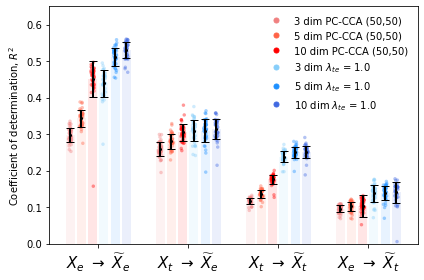

In [11]:
col = ['lightcoral', 'tomato', 'red',
       'lightskyblue', 'dodgerblue', 'royalblue']

lbl = ['3 dim PC-CCA (50,50)',
       '5 dim PC-CCA (50,50)',
       '10 dim PC-CCA (50,50)',
       r'3 dim $\lambda_{te}$ = 1.0',
       r'5 dim $\lambda_{te}$ = 1.0',
       r'10 dim $\lambda_{te}$ = 1.0']

h_list = []
plt.figure(figsize=(6, 4))
for grp, key in enumerate(['XE_from_XE_',
                           'XE_from_XT_',
                           'XT_from_XT_',
                           'XT_from_XE_']):
    meas = 'R2_val'
    key = key+meas
    for i, df in enumerate(df_list):

        x_value = i+(8*grp)
        y_values = df[key].values
        x_values_scattered = x_value*np.ones_like(y_values) + (np.random.rand(y_values.size,)-0.5)*0.3

        plt.bar(x_value, np.mean(y_values), color=col[i], alpha=0.1)
        plt.scatter(x=x_values_scattered, y=y_values, s=12, c=col[i], alpha=0.4, label=lbl[i], edgecolor='None')
        plt.errorbar(x_value, np.mean(y_values), np.std(y_values), marker='.', ms=4, color='k', capsize=4, lw=2, elinewidth=2)
        h = mlines.Line2D([], [], color=col[i], linestyle='None', marker='o', markersize=5, label=lbl[i])
        if grp == 0:
            h_list.append(h)  # To get handles for legends

plt.legend(handles=h_list, labels=lbl, frameon=False)
ax = plt.gca()
ax.set_ylim(0, 0.65)
ax.set_xlabel('')
ax.set_xticks(np.array([0, 1, 2, 3])*8+2.5)
ax.set_xticklabels([r'$X_{e}$ $\rightarrow$ $\widetilde{X}_{e}$',
                    r'$X_{t}$ $\rightarrow$ $\widetilde{X}_{e}$',
                    r'$X_{t}$ $\rightarrow$ $\widetilde{X}_{t}$',
                    r'$X_{e}$ $\rightarrow$ $\widetilde{X}_{t}$', ])
ax.set_ylabel(r'Coefficient of determination, $R^2$')
ax.tick_params(axis='x', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('../assets/Fig_ED_5.png', dpi=300)
plt.show()

#### Plot comparisons with and without augmentation

Results from additional runs to verify that *augmentation* (i.e. using cross modal representations as part of training) substantially improves cross-modal reconstruction were included in the manuscript. Here the same 43 folds as above are shown. The conclusion remains unchanged.

In [12]:
result_path = Path('../assets')
fname_list = ['reconstruction_pc_dim_T_10_pc_dim_E_10_cca_dim_3.csv',
              'reconstruction_pc_dim_T_50_pc_dim_E_50_cca_dim_3.csv',
              'reconstruction_aT_1-0_aE_1-0_cs_1-0_ad_0_ld_3.csv',
              'reconstruction_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_3.csv']
df_list = []

for fname in fname_list:
    df_list.append(pd.read_csv((result_path / fname).resolve()))

#Remove single cross validation fold from all - corrupted reconstruction data in one of the experiment configurations.
for df in df_list: df.drop(index=35, inplace=True)

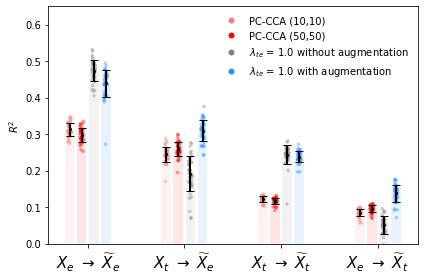

In [13]:
lbl = ['']
col = ['lightcoral',
       'red',
       'gray',
       'dodgerblue']

lbl = ['PC-CCA (10,10)',
       'PC-CCA (50,50)',
       r'$\lambda_{te}$ = 1.0 without augmentation',
       r'$\lambda_{te}$ = 1.0 with augmentation']

h_list = []

plt.figure(figsize=(6, 4))
for grp, key in enumerate(['XE_from_XE_',
                           'XE_from_XT_',
                           'XT_from_XT_',
                           'XT_from_XE_']):
    meas = 'R2_val'
    key = key+meas
    for i, df in enumerate(df_list):

        x_value = i+(8*grp)
        y_values = df[key].values
        x_values_scattered = x_value*np.ones_like(y_values) + (np.random.rand(y_values.size,)-0.5)*0.3

        plt.bar(x_value, np.mean(y_values), color=col[i], alpha=0.1)
        plt.scatter(x=x_values_scattered, y=y_values, s=12, c=col[i], alpha=0.4, label=lbl[i], edgecolor='None')
        plt.errorbar(x_value, np.mean(y_values), np.std(y_values), marker='.', ms=4, color='k', capsize=4, lw=2, elinewidth=2)
        h = mlines.Line2D([], [], color=col[i], linestyle='None', marker='o', markersize=5, label=lbl[i])
        if grp == 0:
            h_list.append(h)

plt.legend(handles=h_list, labels=lbl, frameon=False)
ax = plt.gca()
ax.set_ylim(0, 0.65)
ax.set_xlabel('')
ax.set_xticks(np.array([0, 1, 2, 3])*8+1.5)
ax.set_xticklabels([r'$X_{e}$ $\rightarrow$ $\widetilde{X}_{e}$',
                    r'$X_{t}$ $\rightarrow$ $\widetilde{X}_{e}$',
                    r'$X_{t}$ $\rightarrow$ $\widetilde{X}_{t}$',
                    r'$X_{e}$ $\rightarrow$ $\widetilde{X}_{t}$', ])
ax.set_ylabel(r'$R^2$')
ax.tick_params(axis='x', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('../assets/Fig_ED_4.png', dpi=300)
plt.show()